## Working with MultiDimensional Image Service with Raster Analytics


#### Connect to ArcGIS Online (AGOL) or an ArcGIS Enterprise Portal to save outputs

In [7]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster import *

In [2]:
# Connect to your ArcGIS Enteprise or AGOL
portal_url = 'https://gis.earthdata.nasa.gov/portal'
gis = GIS(portal_url) #anonymous user

In [3]:
# Check the version of Python API
arcgis.__version__

'2.3.0.3'

In [4]:
#query Portal Content
query="POWER Annual"
max_items=3
portal_content = gis.content.advanced_search(query=query, max_items=max_items)
for item in portal_content['results']:
        display (item)

<Item title:"POWER Annual Meteorology" type:Imagery Layer owner:NASA_POWER>

<Item title:"POWER Annual Meteorology: WMS" type:WMS owner:NASA_POWER>

<Item title:"POWER Annual Radiation" type:Imagery Layer owner:NASA_POWER>

In [5]:
power_annual_meterology_id="525f42d17c6c4d9da5f359ca9ab7791f"
power_annual_meterology_item=gis.content.get(power_annual_meterology_id)
power_annual_meterology_item

<Item title:"POWER Annual Meteorology" type:Imagery Layer owner:NASA_POWER>

In [8]:
m = gis.map()
m.add_layer(power_annual_meterology_item)
m.time_slider = True
#m.center = [34.09042, -118.71511]  # [latitude, longitude]
#m.zoom = 11
m

MapView(layout=Layout(height='400px', width='100%'), time_slider=True)

# Using the Image Service API

Resource: https://developers.arcgis.com/python/guide/using-imagery-layers/

In [7]:
# Load data from REST end point
service_url = "https://gis.earthdata.nasa.gov/image/rest/services/POWER/POWER_901_ANNUAL_METEOROLOGY_UTC/ImageServer"
md_raster = Raster(service_url, is_multidimensional=True, engine=None, gis=gis)

In [8]:
#Print Image Service Multidimensional Info
#print (md_raster.multidimensional_info)

In [9]:
# Print basic information about the multidimensional dataset
print(f"Dataset extent: {md_raster.extent}")
print(f"Variable names: {md_raster.variable_names}")
#print(f"Time extent: {md_raster.time_extent}")

Dataset extent: {
  "xmin": -180.3125,
  "ymin": -90.25,
  "xmax": 179.6875,
  "ymax": 90.25,
  "spatialReference": {
    "wkid": 4326,
    "latestWkid": 4326
  }
}
Variable names: ['CDD10', 'CDD18_3', 'DISPH', 'EVLAND', 'EVPTRNS', 'FROST_DAYS', 'GWETTOP', 'HDD10', 'HDD18_3', 'PBLTOP', 'PRECSNOLAND_SUM', 'PRECTOTCORR_SUM', 'PS', 'QV10M', 'QV2M', 'RH2M', 'T10M', 'T2M', 'T2MDEW', 'T2MWET', 'TO3', 'TQV', 'TS', 'WD10M', 'WD2M', 'WD50M', 'WS10M', 'WS2M', 'WS50M']


In [10]:
# Check your Raster function templates
md_raster = ImageryLayer(service_url, gis=gis)

for fn in md_raster.properties.rasterFunctionInfos:
    print(fn['name'])

None


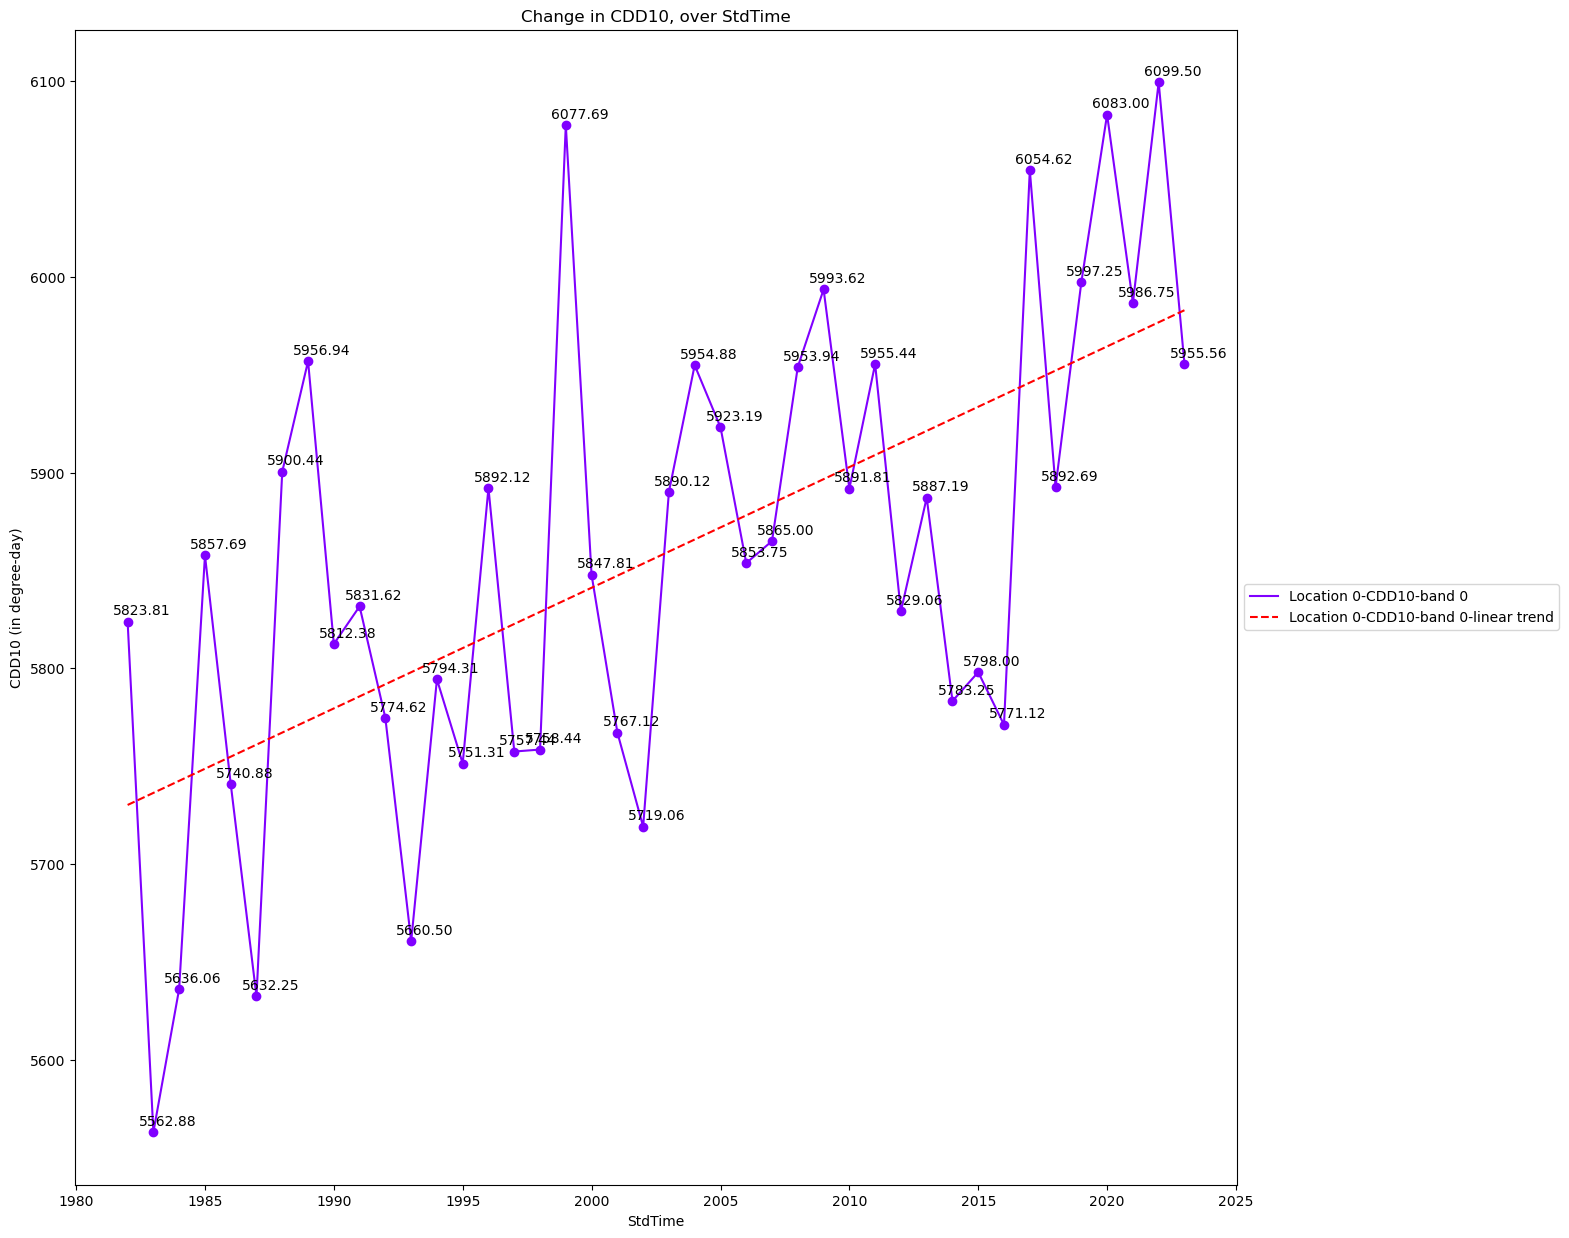

In [14]:
#Generate Temporal Profile graph
from arcgis.geometry import *

#Geometry
point1 = Point({"x" : 25.773, "y" : -80.216, "spatialReference" : {"wkid" : 3857}})
#point2 = Point({"x" : 0, "y" : 0, "spatialReference" : {"wkid" : 3857}})

#Trend Type
trend_type ="linear" #linear

#Variables
variables = ["CDD10"]

#Temporal Profile
md_raster.temporal_profile(points = [point1], time_field = "StdTime", trend_type = trend_type, variables = variables, show_values=True)

# Using Raster Functions on Imagery Layer

Resource: https://developers.arcgis.com/python/api-reference/arcgis.raster.functions.html#clip

## Set extent, clip and display ouput in map with basemap


In [14]:
# Access the World contient item from the Living Atlas to use it as a boundary extent.
# Title: World Continents | Type: Feature Service | Owner: esri_livingatlas

gis_agol = GIS('home') #AGOL anonymous user
item = gis_agol.content.get("57c1ade4fa7c4e2384e6a23f2b3bd254")
item

Exception: You do not have permissions to access this resource or perform this operation.
(Error Code: 403)

In [16]:
data = ImageryLayer(service_url, gis=gis)

#Now get the extent for the area you would like to select. In this case, I selected Australia
from arcgis.geocoding import geocode

# Use geocoding to get the location of the study area in the spatial reference of the input data for the analysis.
study_area_location = geocode(address='australia', out_sr=data.extent['spatialReference'])

# Get the geographic extent of the study area.
# This extent will be used for displaying the input data and output results.
study_area_extent = study_area_location[0]['extent']
study_area_extent

{'xmin': 111.547031198,
 'ymin': -48.64693157,
 'xmax': 157.421031198,
 'ymax': -2.77293157}

## Clip to a spatial extent

In [17]:
from arcgis.raster.functions import clip #Import clip function

# Select Australia:
country_lyr = item.layers[0]
study_area_query = country_lyr.query("CONTINENT='australia'", return_geometry=True)

# Get the geometry of the Australia feature.
# We will use this geometry to extract the input data for the study area.
study_area_geom= study_area_query.features[0].geometry
study_area_geom['spatialReference'] = study_area_query.spatial_reference

#study_area_geom

# Set your extend
data.extent = study_area_extent

#draw output on map
Clipped_study_area = clip(raster=data, geometry=study_area_geom)
map = gis.map("Australia")
map.time_slider = True
map.add_layer(Clipped_study_area)
map

MapView(layout=Layout(height='400px', width='100%'), time_slider=True)

## Export subsetted file to a Tiff File

In [ ]:
#Export Image
#ADD FILTER FOR SINGLE RASTER
imagery_layer.export_image(size=[1400, 600],
                           export_format="tiff",
                           f="image",
                           save_folder=r"/path/to/save_folder",
                           save_file="my_raster.tif")

# Using analytics module -  Subset Multidimensional Raster Function

Resource: https://developers.arcgis.com/python/api-reference/arcgis.raster.analytics.html#subset-multidimensional-raster

In [ ]:
# This creates a new multidimensional image service with variables cceiling and ccover for StdTime  dimensions
# values - 2018-12-31T06:00:00 and  2018-12-31T11:00:00
from arcgis.raster.analytics import subset_multidimensional_raster
subset_output = subset_multidimensional_raster(input_multidimensional_raster=Clipped_study_area, 
                                               variables=["T2M"],
                                               dimension_definition='BY_VALUE',
                                               dimension_values=[{"dimension":"StdTime", "value":"2018-12-31T06:00:00"},
                                                                 {"dimension":"StdTime", "value":"2018-12-31T11:00:00"}],
                                               output_name="time_subset_T2M_aus", 
                                               gis=gis)

In [ ]:
lyr = subset_output.layers[0]

In [ ]:
lyr.extent = study_area_extent

In [ ]:
lyr

In [ ]:
savedimg = lyr2.export_image(f='image', export_format='tiff', save_folder='.', save_file='australia_subset.tif')

In [ ]:
# Check your Raster function templates

for fn in data.properties.rasterFunctionInfos:
    print(fn['name'])

In [ ]:
# Select the variable you would like from RFT for vizualization
from arcgis.raster.functions import apply
apply(data,"all_sfc_sw_diff")

#apply(data,"Clear-Sky Surface Short Wave Diffuse Flux")

In [ ]:
#create histogram of area in service
ida = {
        "spatialReference": {"wkid": 4326},
        "xmax": -81,
        "xmin": -91,
        "ymax": 30,
        "ymin": 23
      }

#aoi_geometry = Geometry(aoi)

comp_stats_hist_01 = data.compute_stats_and_histograms(geometry=ida,
                                                          rendering_rule={"rasterFunction":None},
                                                          time="1630211400000")
print(comp_stats_hist_01)


In [ ]:
.

# TimingSession


In [ ]:
import requests
from arcgis.gis import GIS
from datetime import datetime

class TimingSession(requests.Session):
    def request(self, *args, **kwargs):
        start_time = datetime.now()
        response = super().request(*args, **kwargs)
        end_time = datetime.now()
        response.elapsed_time = end_time - start_time
        return response

# Override the requests session in the GIS
gis = GIS("https://www.arcgis.com", "username", "password")
gis._con.session = TimingSession()

# Make a request and capture the elapsed time
response = gis.content.search("type:Feature Service", max_items=5)

# Assuming `search` uses `requests` under the hood
print(f"Request took: {response.elapsed_time.total_seconds()} seconds")